In [8]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [10]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          emailAttendeesText = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          emailAttendeesList = emailAttendeesText.split("; ")
          for emailAttendee in emailAttendeesList:
            if emailAttendee not in attendees:
              attendees.append(emailAttendee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def readCsv(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def showMissingValues(df):
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False).reset_index(drop=True)
  display(missingValueDf)

In [11]:
def readAndWritePreprocessedData(preprocessedData, masters):
  ## Decisiones propias para el modelo

  # Transformar la data a dataframe
  df = pd.DataFrame(preprocessedData)

  for i in range(0, len(masters)):
    masters[i] = pd.DataFrame(masters[i])

  # Eliminando columnas que son datos sensibles de los candidatos
  sensitiveColumns = [
    "nombreCompleto", "numeroDocumento", "fechaNacimiento", "direccion", "numeroCasa", "numeroCelular", "correoElectronico"
  ]
  df = df.drop(columns=sensitiveColumns)

  # Eliminando columnas que no se usarán, porque no son relevantes para el modelo
  nonRelevanceColumns = [
    "fechaPostulacion", "idConvocatoria", "objetivoLaboral", "descripcionUltimoTrabajo"
  ]
  df = df.drop(columns=nonRelevanceColumns)

  # Eliminando columnas normadas por Ley N° 26772: Igualdad de oportunidades y de trato
  lawRestrictiveColumns = [
    "estadoCivil", "paisNacimiento"
  ]
  df = df.drop(columns=lawRestrictiveColumns)

  # Aplicar las equivalencias a los campos: jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationInstitution, lastEducationArea, lastEducationName
  equivalences = ["nombrePerfilConvocatoria", "empresaUltimoTrabajo", "nombreUltimoTrabajo", "institucionUltimoEstudio", "nombreUltimoEstudio"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalencia"]
    df = df.drop(columns=["equivalencia", "cantidad", "igual"])

  ## Decisiones por la metodología

  # Analisis de valores nulos
  # Reemplazando las cadenas vacias a NaN
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  for column in categoricalColumns:
    df[column] = df[column].replace('',None,regex = True).astype("object")

  # Reemplazando los ceros a NaN
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].replace(0,None).astype('float64')

  # Obteniendo el porcentaje de nulos por columna
  showMissingValues(df)
  
  # Tecnica 1: Eliminar la columna si sobrepasa el 30% de nulos
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Tecnica 2: Reemplazar NaN por aleatorizacion de valores no nulos, para variables categoricas
  np.random.seed(0)

  for column in categoricalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else np.random.choice(df[column].dropna().tolist()))

  # Tecnica 3: Reemplazar NaN por el promedio de valores no nulos, para variables numericas
  for column in numericalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else round(float(df[column].dropna().mean()), 1) )

  # Obteniendo el nuevo porcentaje de nulos por columna
  showMissingValues(df)

  # Reemplazo de valores atipicos (outliers) (variables numericas)
  # Analizando valores atipicos extremos
  for column in numericalColumns:
    firstQuartil, thirdQuartil = np.percentile(df[column], 25), np.percentile(df[column], 75)
    interQuartilRange = thirdQuartil - firstQuartil
    bottomLimit, topLimit = firstQuartil - 3*interQuartilRange, thirdQuartil + 3*interQuartilRange

    # Reemplazando los valores
    df[column] = df[column].map(lambda x: bottomLimit if x < bottomLimit else x)
    df[column] = df[column].map(lambda x: topLimit if x > topLimit else x)

  # Regresando el dataframe a array de dicts
  preprocessedData = df.to_dict('records')

  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')

  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [12]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()
    else:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()

In [13]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  isPreprocessed = False

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readJson(os.path.join(inputMainFolder, 'result.json'))
  
  # Leyendo archivos maestros
  jobProfileName = readCsv(os.path.join(inputMastersFolder, 'nombrePerfilConvocatoria.csv'))
  lastWorkCompany = readCsv(os.path.join(inputMastersFolder, 'empresaUltimoTrabajo.csv'))
  lastWorkName = readCsv(os.path.join(inputMastersFolder, 'nombreUltimoTrabajo.csv'))
  lastEducationInstitution = readCsv(os.path.join(inputMastersFolder, 'institucionUltimoEstudio.csv'))
  lastEducationName = readCsv(os.path.join(inputMastersFolder, 'nombreUltimoEstudio.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(outputFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkName, lastEducationInstitution, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-06-03 14:24:23.841210
Se inició el procesamiento


,columnName,percentMissing
0,otrasHabilidades,22.864962
1,habilidadesTecnicas,11.795791
2,idiomas,7.426630
3,diasUltimoEstudio,6.860432
4,diasUltimoTrabajo,5.699726
5,empresaUltimoTrabajo,5.435501
6,aniosExperiencia,5.426064
7,areaUltimoTrabajo,5.360008
8,nombreUltimoTrabajo,5.360008
9,numeroTrabajos,5.360008


,columnName,percentMissing
0,nombrePerfilConvocatoria,0.0
1,paisUltimoEstudio,0.0
2,otrasHabilidades,0.0
3,idiomas,0.0
4,habilidadesTecnicas,0.0
5,numeroEstudios,0.0
6,aniosEstudio,0.0
7,gradoUltimoEstudio,0.0
8,estadoUltimoEstudio,0.0
9,nombreUltimoEstudio,0.0


Se terminó el preprocesamiento
nombrePerfilConvocatoria     object
paisResidencia               object
sueldoPretendido            float64
diasUltimoTrabajo           float64
empresaUltimoTrabajo         object
paisUltimoTrabajo            object
areaUltimoTrabajo            object
nombreUltimoTrabajo          object
aniosExperiencia            float64
numeroTrabajos              float64
diasUltimoEstudio           float64
institucionUltimoEstudio     object
paisUltimoEstudio            object
areaUltimoEstudio            object
nombreUltimoEstudio          object
estadoUltimoEstudio          object
gradoUltimoEstudio           object
aniosEstudio                float64
numeroEstudios              float64
habilidadesTecnicas         float64
idiomas                     float64
otrasHabilidades            float64
contratado                    int64
dtype: object
nombrePerfilConvocatoria    10597
paisResidencia              10597
sueldoPretendido            10597
diasUltimoTrabajo        

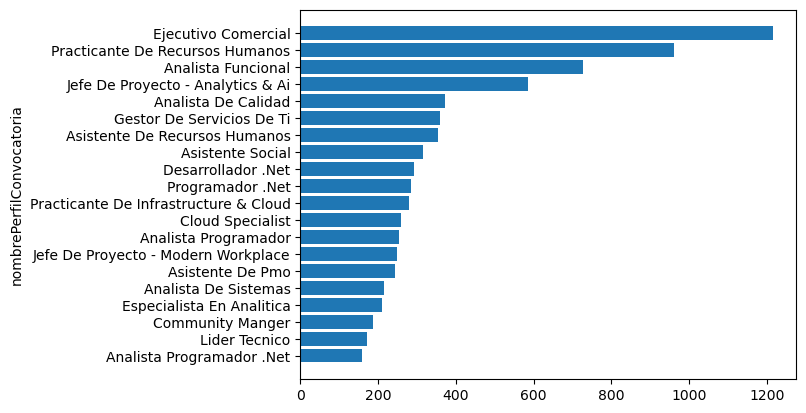

Peru                    10412
Venezuela                 148
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
El Salvador                 1
Panama                      1
Espana                      1
Costa Rica                  1
Francia                     1
Bolivia                     1
Name: paisResidencia, dtype: int64


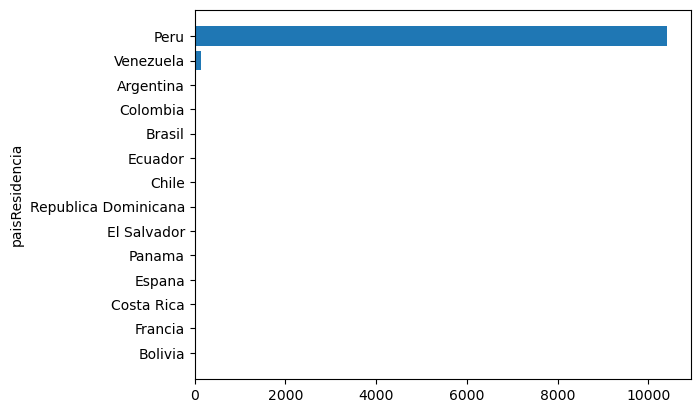

5000.0    641
2500.0    639
2000.0    601
3500.0    593
3000.0    574
4000.0    560
1500.0    484
6000.0    463
4301.8    439
4500.0    434
1200.0    364
1800.0    360
5500.0    326
6500.0    305
1025.0    298
7000.0    296
1000.0    282
930.0     227
1.0       210
8000.0    208
Name: sueldoPretendido, dtype: int64


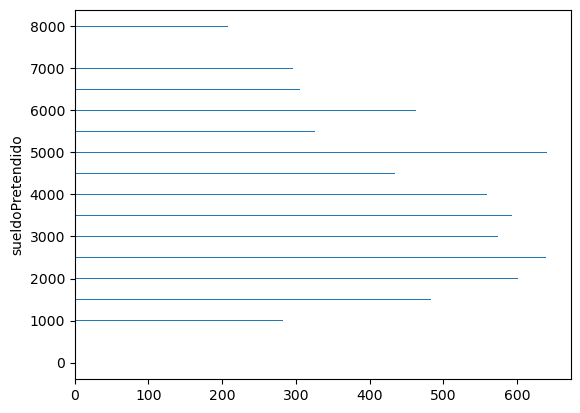

657.3     604
2620.0    241
153.0     167
61.0      165
92.0      156
122.0     152
365.0     140
184.0     105
212.0      98
31.0       88
214.0      87
91.0       87
151.0      84
181.0      83
334.0      82
273.0      76
183.0      70
59.0       66
275.0      65
366.0      63
Name: diasUltimoTrabajo, dtype: int64


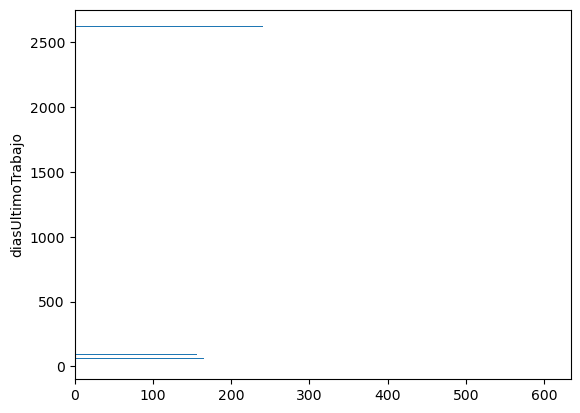

Freelance                                          214
Ntt Data Peru S.A.C.                               187
Canvia S.A.C.                                      175
Global Hitss Peru S.A.C.                           128
Mdp Consulting S.A.C.                              126
Manpower Professional Services S.A.                118
Indra Peru S.A.                                    100
Telefonica Del Peru                                 93
Banco De Credito Del Peru - Bcp                     85
Stefanini It Solutions                              78
Tata Consultancy Services                           62
Corporacion Sapia S.A.                              61
Universidad Peruana De Ciencias Aplicadas (Upc)     48
Ferreyros S.A.                                      45
Oficina Nacional De Procesos Electorales (Onpe)     44
Tgestiona Sac                                       44
America Movil Peru S.A.C.                           41
Pontificia Universidad Catolica Del Peru            41
Zoluxiones

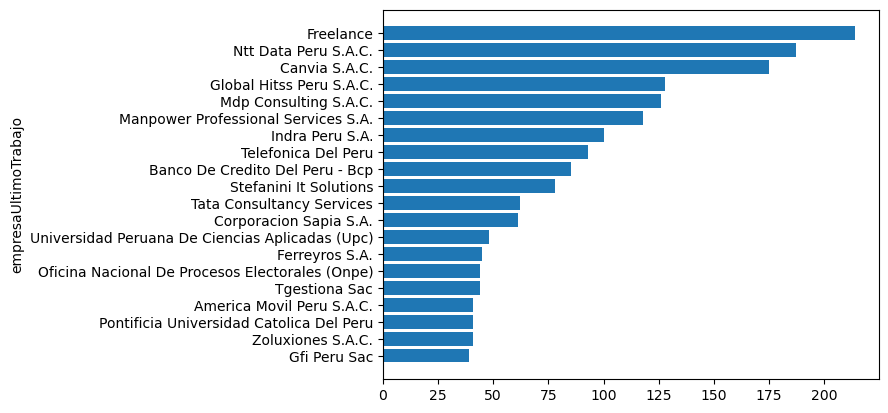

Peru              10411
Estados Unidos       33
Venezuela            26
Espana               25
Colombia             18
Brasil               16
Chile                14
Argentina             8
Ecuador               7
Mexico                4
Costa Rica            3
Reino Unido           3
Paises Bajos          3
Albania               3
Francia               2
Italia                2
Finlandia             2
Panama                2
Australia             2
Corea Del Sur         2
Name: paisUltimoTrabajo, dtype: int64


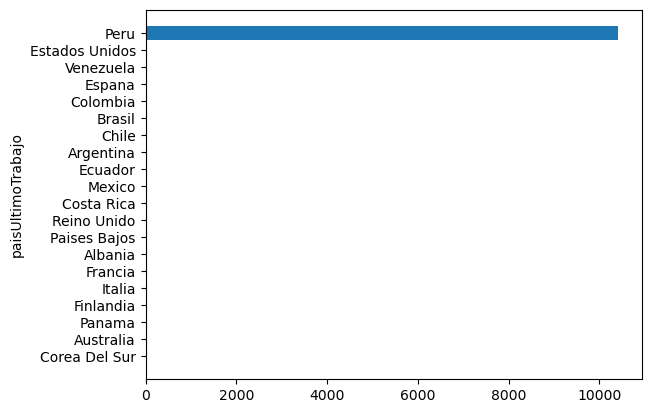

Tecnologia / Sistemas            1156
Tecnologias De La Informacion    1115
Liderazgo De Proyecto             656
Programacion                      629
Comercial                         597
Sistemas                          532
Recursos Humanos                  478
Analisis Funcional                311
Ventas                            283
Administracion                    282
Analisis De Datos                 255
Infraestructura                   224
Soporte Tecnico                   215
Atencion Al Cliente               176
Seguridad Informatica             170
Otras Ingenierias                 166
Testing / Qa / Qc                 145
Desarrollo De Negocios            142
Telecomunicaciones                128
Administracion De Personal        124
Name: areaUltimoTrabajo, dtype: int64


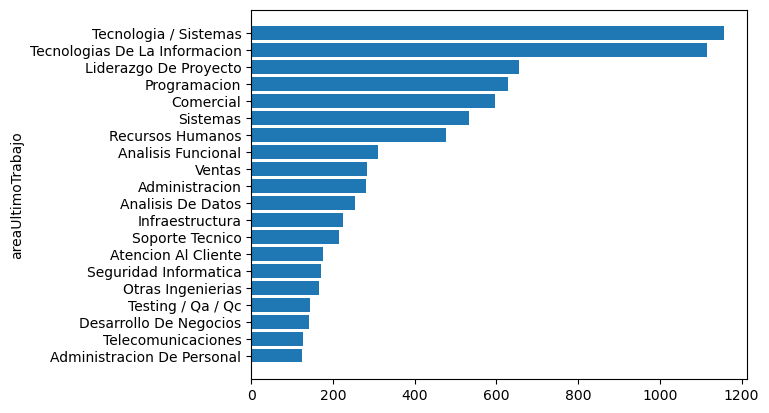

Analista Programador                            598
Analista De Sistemas                            291
Analista Funcional                              242
Jefe De Proyectos                               190
Asistente Administrativo                        129
Analista De Calidad                             119
Trabajadora Social                              110
Ejecutivo Comercial                             106
Asistente De Recursos Humanos                   102
Supervisor De Infraestructura De Redes Cisco     92
Project Manager                                  92
Docente                                          79
Practicante Profesional                          79
Asesor Comercial                                 79
Practicante Pre Profesional                      72
Soporte Tecnico                                  70
Lider Tecnico                                    68
Gestor De Proyectos                              64
Practicante De Recursos Humanos                  63
Gerente De P

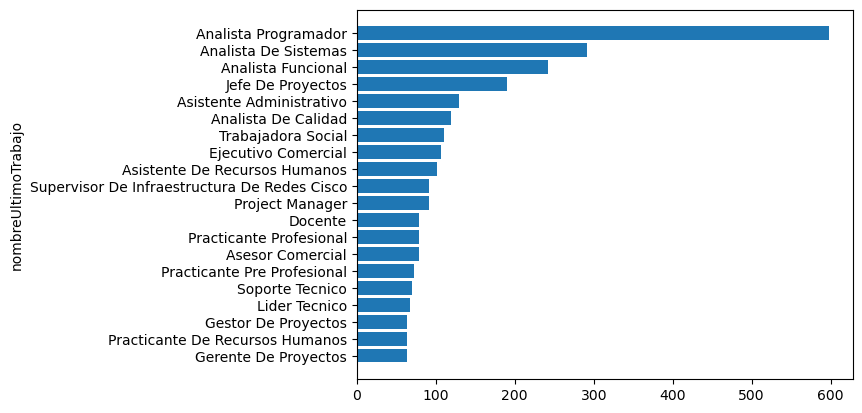

8.7     645
4.8     106
4.3     106
8.8      98
5.8      94
0.2      93
2.8      91
1.9      90
6.8      88
32.9     85
5.9      85
7.3      83
8.4      83
7.7      83
1.2      81
1.0      79
0.5      79
7.0      79
8.3      79
6.3      79
Name: aniosExperiencia, dtype: int64


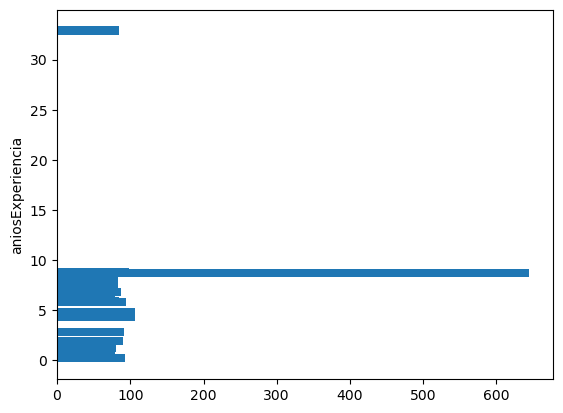

5.0     1335
4.0     1229
6.0     1113
3.0     1050
7.0      984
8.0      758
2.0      749
1.0      672
6.1      568
9.0      558
10.0     422
11.0     289
12.0     251
13.0     157
14.0     128
15.0      99
17.0      63
20.0      52
16.0      48
19.0      40
Name: numeroTrabajos, dtype: int64


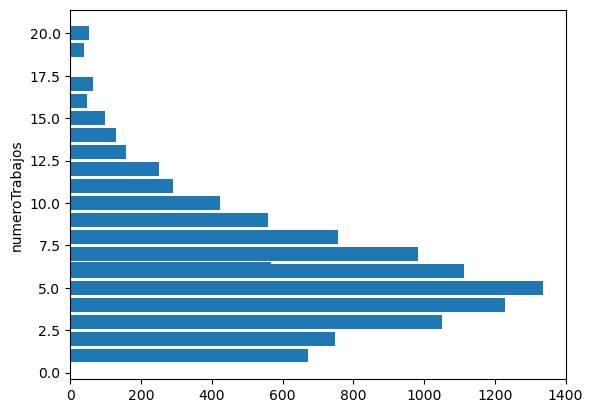

1226.0    729
31.0      322
61.0      252
30.0      220
1736.0    204
92.0      162
122.0     148
1705.0    148
1948.0    132
153.0     124
2101.0    106
1795.0    105
91.0       87
1826.0     82
183.0      67
2161.0     65
1157.0     64
1096.0     64
1218.0     62
2070.0     61
Name: diasUltimoEstudio, dtype: int64


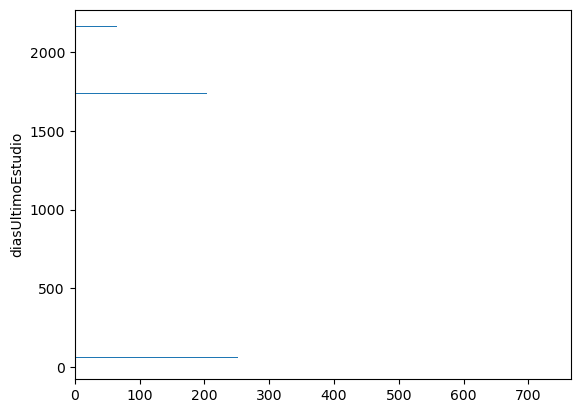

Universidad Peruana De Ciencias Aplicadas    945
Universidad Tecnologica Del Peru             553
Instituto Cibertec                           450
Pontificia Universidad Catolica Del Peru     365
Universidad Privada Del Norte                357
Universidad San Ignacio Del Loyola           340
Universidad Nacional Mayor De San Marcos     336
Universidad Cesar Vallejo                    311
Universidad Esan                             299
Universidad De Lima                          255
Universidad Nacional De Ingenieria           231
Universidad De San Martin De Porres          227
Universidad Ricardo Palma                    206
Universidad Nacional Federico Villarreal     198
Instituto San Ignacio De Loyola              188
Universidad Inca Garcilaso De La Vega        185
Tecsup                                       130
Instituto Superior Tecnologico Idat          123
Universidad Del Pacifico                     116
Universidad Alas Peruanas                    105
Name: institucionUlt

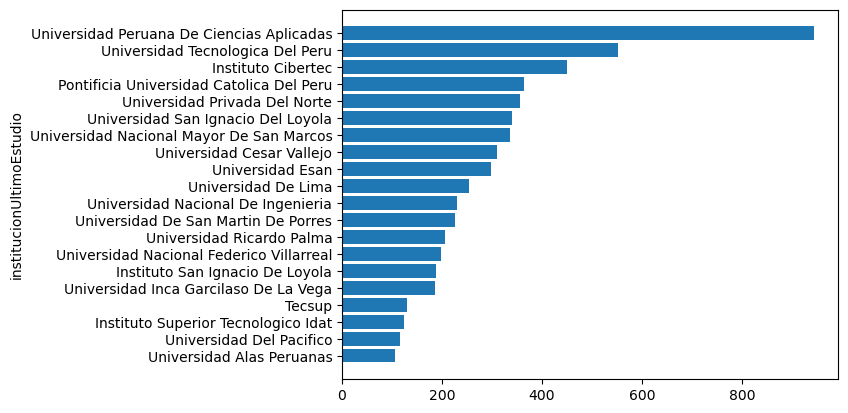

Peru              9958
Espana             208
Venezuela          167
Estados Unidos      78
Mexico              35
Argentina           23
Colombia            20
Brasil              19
Chile               18
Costa Rica          15
Canada               9
Australia            7
Ecuador              6
Bolivia              6
Francia              5
Alemania             3
Reino Unido          3
India                3
Internacional        2
Cuba                 2
Name: paisUltimoEstudio, dtype: int64


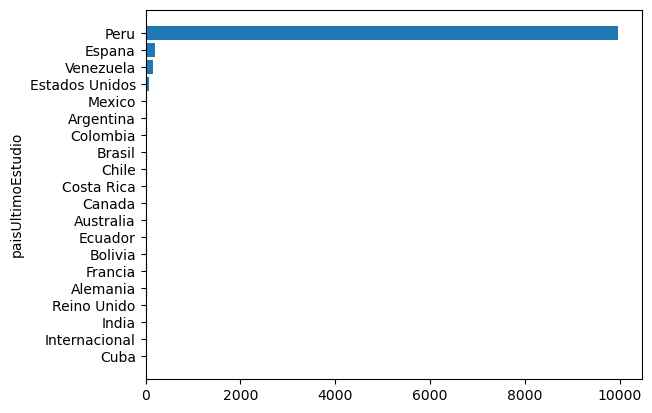

Ing. En Sistemas                  2464
Tecnologias De La Informacion     1326
Adm. De Empresas                  1188
Ing. Informatica                   653
Ing. Industrial                    515
Computacion / Informatica          502
Marketing / Comercializacion       374
Otra                               367
Recursos Humanos / Relac. Ind.     366
Psicologia                         354
Ing. - Otros                       205
Trabajo Social                     161
Analisis De Sistemas               151
Ing. Telecomunicaciones            134
Programacion                       124
Telecomunicaciones                 121
Procesos / Calidad Total           115
Finanzas                           101
Ing. Electronica                    98
Bachiller                           97
Name: areaUltimoEstudio, dtype: int64


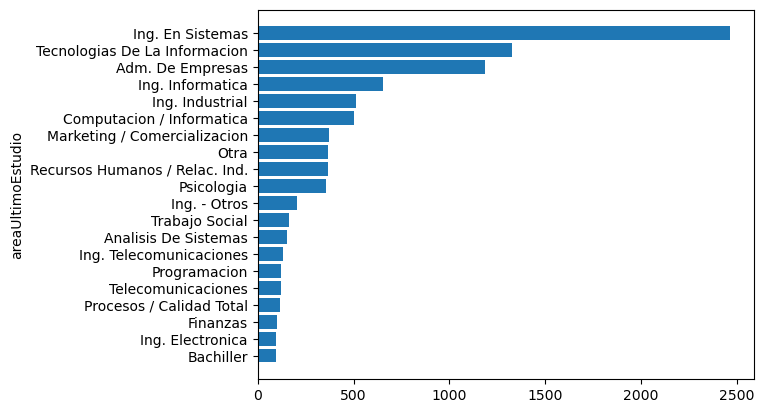

Ingenieria De Sistemas                       1688
Ingenieria Industrial                         345
Psicologia                                    311
Administracion De Empresas                    232
Computacion E Informatica                     184
Mba                                           142
Bachiller En Ingenieria De Sistemas           138
Administracion                                130
Marketing                                     129
Administracion Y Negocios Internacionales      96
Ingles                                         87
Scrum Master                                   86
Itil                                           78
Gestion De Proyectos                           77
Trabajo Social                                 71
Ingenieria Informatica                         63
Ingenieria De Redes Y Comunicaciones           62
Ingenieria De Software                         57
Tecnico En Computacion E Informatica           55
Ingenieria De Computacion Y Sistemas           54


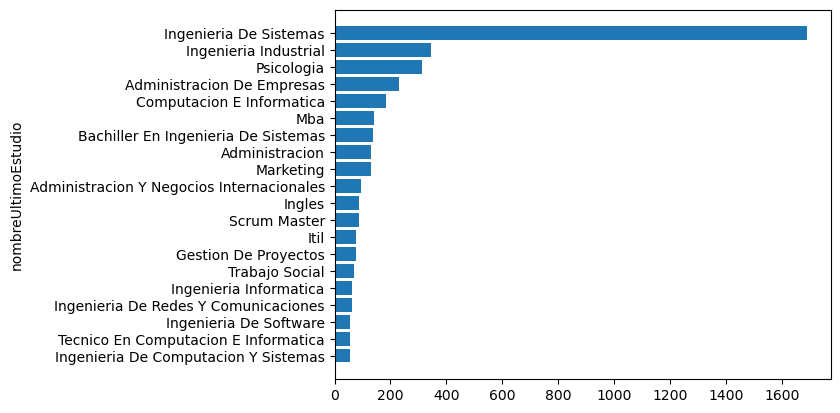

Graduado      6976
En Curso      3443
Abandonado     178
Name: estadoUltimoEstudio, dtype: int64


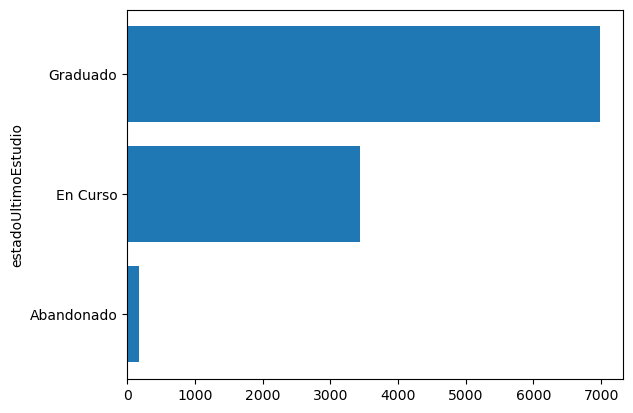

Universitario        5224
Otro                 2391
Posgrado             1271
Terciario/Tecnico    1051
Master                635
Doctorado              14
Secundario             11
Name: gradoUltimoEstudio, dtype: int64


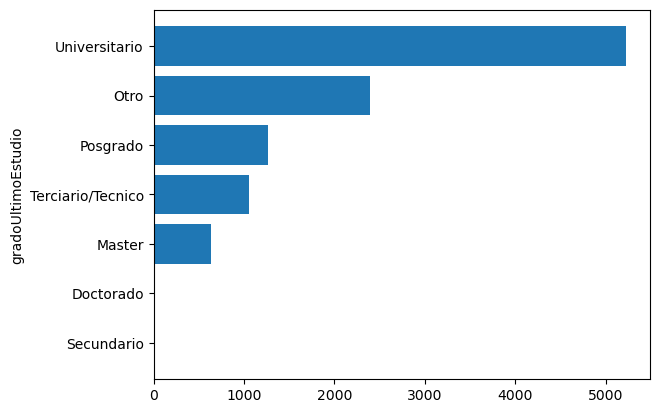

5.3     330
4.8     329
6.3     279
5.8     256
7.7     253
4.7     245
5.0     208
6.8     204
4.9     200
7.8     182
5.9     179
5.7     178
21.0    173
5.4     163
7.3     162
7.4     154
6.5     149
4.5     140
8.3     133
6.9     129
Name: aniosEstudio, dtype: int64


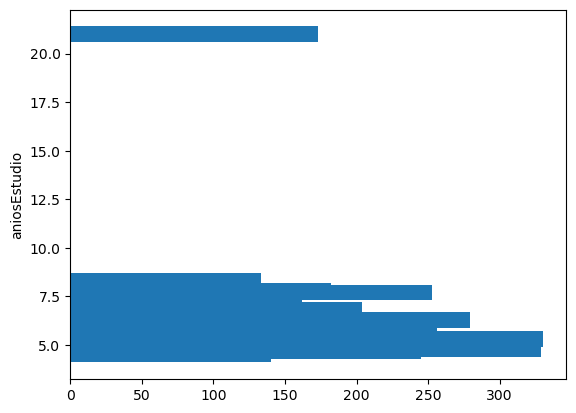

1.0     3918
2.0     2440
3.0     1217
4.0      734
5.0      492
6.0      442
7.0      304
13.0     283
8.0      197
9.0      152
3.2      128
11.0     121
10.0      97
12.0      72
Name: numeroEstudios, dtype: int64


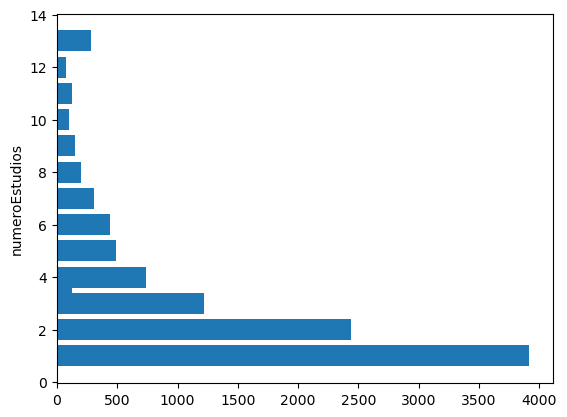

9.4     1250
1.0     1153
3.0      880
2.0      828
4.0      709
5.0      613
6.0      546
7.0      512
9.0      469
8.0      445
11.0     355
10.0     351
35.0     300
12.0     270
13.0     251
16.0     246
14.0     193
15.0     166
17.0     129
18.0     127
Name: habilidadesTecnicas, dtype: int64


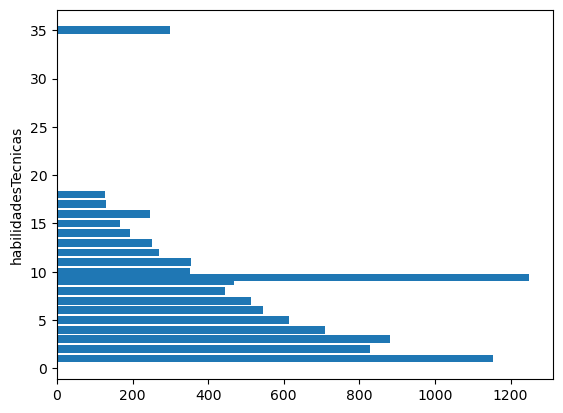

1.0    7381
2.0    2054
1.3     787
2.2     375
Name: idiomas, dtype: int64


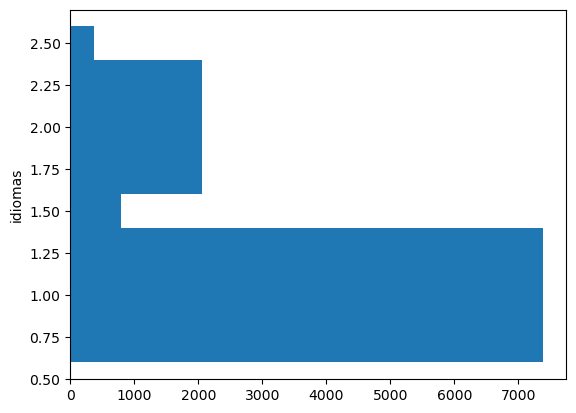

5.4     2423
1.0     1789
2.0     1209
3.0      871
4.0      777
5.0      665
6.0      523
7.0      450
8.0      360
18.0     286
9.0      280
10.0     228
11.0     184
12.0     152
13.0     123
14.0      98
15.0      74
17.0      55
16.0      50
Name: otrasHabilidades, dtype: int64


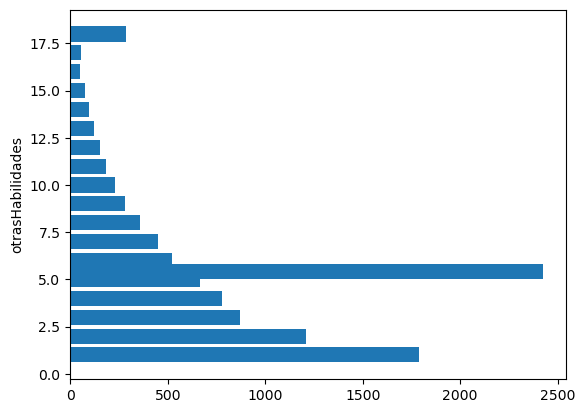

0    10091
1      506
Name: contratado, dtype: int64


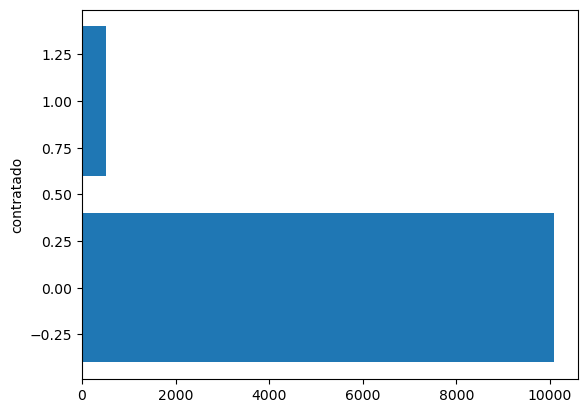

Fin: 2023-06-03 14:24:35.259152
Tiempo: 0:00:11.417942


In [14]:
if __name__ == "__main__":
  main()